In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print('Tensorflow: {}'.format(tf.__version__))

plt.rcParams['figure.figsize'] = (16, 10)
plt.rc('font', size=15)

Tensorflow: 2.9.2


## Example - sentence classification

In this example, we will implement stacked RNN model for sentence classification. At first, we prepare the sentence data, and its purpose is to clasify the speaker of sentence. If the sentence is spoken by `richard feynman`, the label will be 1, and if `albert einstein` told the target sentence, the label will be 0.

In [7]:
# read data
filePath = '/content/bitaData(1).csv'

data = pd.read_csv(filePath)
data

,date,year,month,day,co,o3,no2,so2,pm10,pm2.5
0,1396-01-01,1396,1,1,0,25,15,0,55.0,58.0
1,1396-01-02,1396,1,2,0,23,15,0,34.0,0.0
2,1396-01-03,1396,1,3,0,22,18,17,47.0,0.0
3,1396-01-04,1396,1,4,0,14,20,17,24.0,0.0
4,1396-01-05,1396,1,5,14,20,17,16,31.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1820,1400-12-25,1400,12,25,7,24,11,19,84.0,93.0
1821,1400-12-26,1400,12,26,6,25,11,18,27.0,41.0
1822,1400-12-27,1400,12,27,5,26,11,19,20.0,33.0
1823,1400-12-28,1400,12,28,7,25,11,17,36.0,39.0


In [13]:
data.replace(to_replace = 0, value = pd.NA, inplace=True)

In [14]:
# check the null data
data.isnull().sum()

Date       0
Year       0
Month      0
Day        0
CO       367
O3       165
NO2      561
SO2      270
PM10     424
PM2.5    480
dtype: int64

In [15]:
# drop the row no column and rename the columns
#data.drop(["date"], axis=1, inplace=True)
data.rename(columns = {'year': 'Year',
                       'month': 'Month',
                       "day":"Day",
                       "date":"Date",
                       'co': "CO",
                       'o3': 'O3',
                       'pm2.5': 'PM2.5',
                       'pm10': 'PM10',
                       'no2': 'NO2',
                       'so2': 'SO2',
                       }, inplace = True)
data

,Date,Year,Month,Day,CO,O3,NO2,SO2,PM10,PM2.5
0,1396-01-01,1396,1,1,<NA>,25,15,<NA>,55.0,58.0
1,1396-01-02,1396,1,2,<NA>,23,15,<NA>,34.0,<NA>
2,1396-01-03,1396,1,3,<NA>,22,18,17,47.0,<NA>
3,1396-01-04,1396,1,4,<NA>,14,20,17,24.0,<NA>
4,1396-01-05,1396,1,5,14,20,17,16,31.0,<NA>
...,...,...,...,...,...,...,...,...,...,...
1820,1400-12-25,1400,12,25,7,24,11,19,84.0,93.0
1821,1400-12-26,1400,12,26,6,25,11,18,27.0,41.0
1822,1400-12-27,1400,12,27,5,26,11,19,20.0,33.0
1823,1400-12-28,1400,12,28,7,25,11,17,36.0,39.0


In [16]:
# fill the null values in numerical columns with average specific to certain column
# fill in the missing data in the columns according to the Month average.
unique_Month = pd.unique(data.Month)

# find PM2_5 averages in Month specific
# Equalize the average PM2.5 values to the missing values in PM2_5 specific to Month
temp_data = data.copy()  # set temp_data variable to avoid losing real data
columns = ["CO" ,	"O3", 	"NO2", 	"SO2" ,	"PM10" ,	"PM2.5"] # it can be add more column
for c in unique_Month:
    
    # create Month filter
    Month_filtre = temp_data.Month == c
    # filter data by Month
    fitered_data = temp_data[Month_filtre]
    
    # find average for PM2_5 in specific to Month
    for s in columns:
        mean = np.round(np.mean(fitered_data[s]), 2)
        if ~np.isnan(mean): # if there if average specific to Month
            fitered_data[s] = fitered_data[s].fillna(mean)
            print(f"Missing Value in {s} column fill with {mean} when Month:{c}")
        else: # find average for all data if no average in specific to Month
            all_data_mean = np.round(np.mean(data[s]),2)
            fitered_data[s] = fitered_data[s].fillna(all_data_mean)
            print(f"Missing Value in {s} column fill with {all_data_mean}")
    # Synchronize data filled with missing values in PM2.5 to data temporary            
    temp_data[Month_filtre] = fitered_data

# equate the deprecated temporary data to the real data variable
data = temp_data.copy() 

Missing Value in CO column fill with 15.28 when Month:1
Missing Value in O3 column fill with 17.62 when Month:1
Missing Value in NO2 column fill with 16.58 when Month:1
Missing Value in SO2 column fill with 19.04 when Month:1
Missing Value in PM10 column fill with 50.57 when Month:1
Missing Value in PM2.5 column fill with 52.6 when Month:1
Missing Value in CO column fill with 16.28 when Month:2
Missing Value in O3 column fill with 19.05 when Month:2
Missing Value in NO2 column fill with 23.55 when Month:2
Missing Value in SO2 column fill with 20.41 when Month:2
Missing Value in PM10 column fill with 56.29 when Month:2
Missing Value in PM2.5 column fill with 71.13 when Month:2
Missing Value in CO column fill with 14.93 when Month:3
Missing Value in O3 column fill with 22.42 when Month:3
Missing Value in NO2 column fill with 18.1 when Month:3
Missing Value in SO2 column fill with 21.98 when Month:3
Missing Value in PM10 column fill with 61.66 when Month:3
Missing Value in PM2.5 column fi

<ipython-input-16-3693324f30fb>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fitered_data[s] = fitered_data[s].fillna(mean)


In [17]:
# information about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1825 non-null   object
 1   Year    1825 non-null   int64 
 2   Month   1825 non-null   int64 
 3   Day     1825 non-null   int64 
 4   CO      1825 non-null   object
 5   O3      1825 non-null   object
 6   NO2     1825 non-null   object
 7   SO2     1825 non-null   object
 8   PM10    1825 non-null   object
 9   PM2.5   1825 non-null   object
dtypes: int64(3), object(7)
memory usage: 142.7+ KB


In [18]:
# statistical information about data
data.drop(["Year", "Month", "Day" ,"Date"], axis=1).describe()

,CO,O3,NO2,SO2,PM10,PM2.5
count,1825.0,1825.0,1825.0,1825.0,1825.00,1825.00
unique,86.0,75.0,86.0,74.0,135.00,156.00
top,7.0,15.0,22.0,18.0,67.96,64.76
freq,78.0,96.0,115.0,121.0,62.00,70.00


In [19]:
# drop some columns and reduce memory
data.drop([ "Date", "Year", "Month", "Day"], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   CO      1825 non-null   object
 1   O3      1825 non-null   object
 2   NO2     1825 non-null   object
 3   SO2     1825 non-null   object
 4   PM10    1825 non-null   object
 5   PM2.5   1825 non-null   object
dtypes: object(6)
memory usage: 85.7+ KB


In [27]:


data.head()



,CO,O3,NO2,SO2,PM10,PM2.5
0,15.28,25.0,15.0,19.04,55.0,58.0
1,15.28,23.0,15.0,19.04,34.0,52.6
2,15.28,22.0,18.0,17.0,47.0,52.6
3,15.28,14.0,20.0,17.0,24.0,52.6
4,14.0,20.0,17.0,16.0,31.0,52.6


In [21]:
# create input and output
X = data.drop('PM2.5', axis = 1)
y = data['PM2.5']

In [28]:
# create input and output
X = data.drop('PM10', axis = 1)
y = data['PM10']

In [29]:
# for train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# see train and test dataset shape
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (1460, 5)
y_train: (1460,)
X_test: (365, 5)
y_test: (365,)


In [30]:
#importing the necessary libraries and dependencies
import pandas as pd
import numpy as np
import seaborn as sns;
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import glob
import statistics

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [31]:
# import libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
# make a function that include all regression models
def allRegressors(X_train, X_test, y_train, y_test):
    """
    This function use multiple machine learning regressors and show us the results of them 
    :param X_train: train input
    :param X_test: test input
    :param y_train: train output
    :param y_test: test output
    :return: Root Mean Squared Error (RMSE), Mean Absolute Error (MAE) for each regressors and
    comparison plot for regressors according to RMSE and MAE
    """
    """model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')"""
    #GradientBoostingRegressor(), KNeighborsRegressor(), DecisionTreeRegressor(), RandomForestRegressor(),  MLPRegressor(random_state=1, max_iter=500)
    #, GaussianProcessClassifier(kernel=1.0 * RBF(1.0),random_state=0)
    Regressors = [LinearRegression(), GradientBoostingRegressor(), KNeighborsRegressor(), DecisionTreeRegressor(), RandomForestRegressor(),  MLPRegressor(random_state=1, max_iter=500)]
    mae_dict = {}
    mae_scores = []
    rmse_dict = {}
    rmse_scores = []
    mean_bias_error_dict={}
    mean_bias_error_scores=[]
    r2_dict = {}
    r2_scores = []
    # function for mean absolute error
    def maeScore(regressor):
        """
        :param regressor: regressor model function
        :return: mean absolute error for regressor
        """
        
        clf = regressor.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mae_score = mean_absolute_error(y_test, pred)
        return mae_score
    
    # function for root mean square error
    def rmseScore(regressor):
        """
        :param regressor: regressor model function
        :return: root mean score error for regressor
        """
        clf = regressor.fit(X_train, y_train)
        pred = clf.predict(X_test)
        rmse_score = np.sqrt(mean_squared_error(y_test, pred))
        return rmse_score



    def mean_bias_error(regressor):
        clf = regressor.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mbe_loss = np.sum(y_test - pred)/y_test.size
        return mbe_loss

    def r2(regressor):
        clf = regressor.fit(X_train, y_train)
        pred = clf.predict(X_test)
        r=r2_score(y_test, pred)
        return r

    # mean absolute error, root mean square error for each regressors
    for regressor in Regressors:
        name = regressor.__class__.__name__
        mae_dict[name] = maeScore(regressor)
        mae_scores.append(maeScore(regressor))
        rmse_dict[name] = rmseScore(regressor)
        rmse_scores.append(rmseScore(regressor))
        mean_bias_error_dict[name] = mean_bias_error(regressor)
        mean_bias_error_scores.append(mean_bias_error(regressor))
        r2_dict[name] = r2(regressor)
        r2_scores.append(r2(regressor))
        print("*************************************************************************")
        print(f"{name} Mean Absolute Error = {mae_dict[name]}")
        print(f"{name} Root Mean Square Error = {rmse_dict[name]}")
        print(f"{name} mean bias error = {mean_bias_error_dict[name]}")
        print(f"{name} r2 score = {r2_dict[name]}")
        
    #Plotting the performance of regressors
    def plotPerformance(scores_list, scores_dict, metric:str):
        """
        :param scores_list: list that include evaluation scores 
        :param scores_dict: dictionary that include regressors and evaluation scores
        :param metric: metric name y axis 
        :return: plot of performance comparison of regressors
        """
        
        N = len(Regressors)
        w = 0.5
        x = np.arange(N)
        plt.bar(x, scores_list, width = w, align = 'center', color="g")
        plt.xlabel("Regressors")
        plt.title("Performance Comparison of Regressors")
        plt.ylabel(f"{metric} Error")
        plt.xticks(x, scores_dict.keys(), rotation=90)
        plt.yticks(np.arange(0, np.max(scores_list), np.max(scores_list)/len(scores_list)))
        plt.show()
    
    # call the functions
    plotPerformance(mae_scores, mae_dict, "Mean Absolute")
    plotPerformance(rmse_scores, rmse_dict, "Root Mean Square")
    plotPerformance(mean_bias_error_scores, mean_bias_error_dict, "mean bias error")
    plotPerformance(r2_scores, r2_dict, "r2 score")

*************************************************************************
LinearRegression Mean Absolute Error = 12.193112646862433
LinearRegression Root Mean Square Error = 19.493957504791695
LinearRegression mean bias error = 0.7906920877695937
LinearRegression r2 score = 0.025832798430598714
*************************************************************************
GradientBoostingRegressor Mean Absolute Error = 9.133640002286114
GradientBoostingRegressor Root Mean Square Error = 14.407868325897102
GradientBoostingRegressor mean bias error = 0.7875850906240307
GradientBoostingRegressor r2 score = 0.47075234012894995
*************************************************************************
KNeighborsRegressor Mean Absolute Error = 9.111397260273971
KNeighborsRegressor Root Mean Square Error = 14.933991987757691
KNeighborsRegressor mean bias error = 0.9283835616438355
KNeighborsRegressor r2 score = 0.42827747703402774
********************************************************************

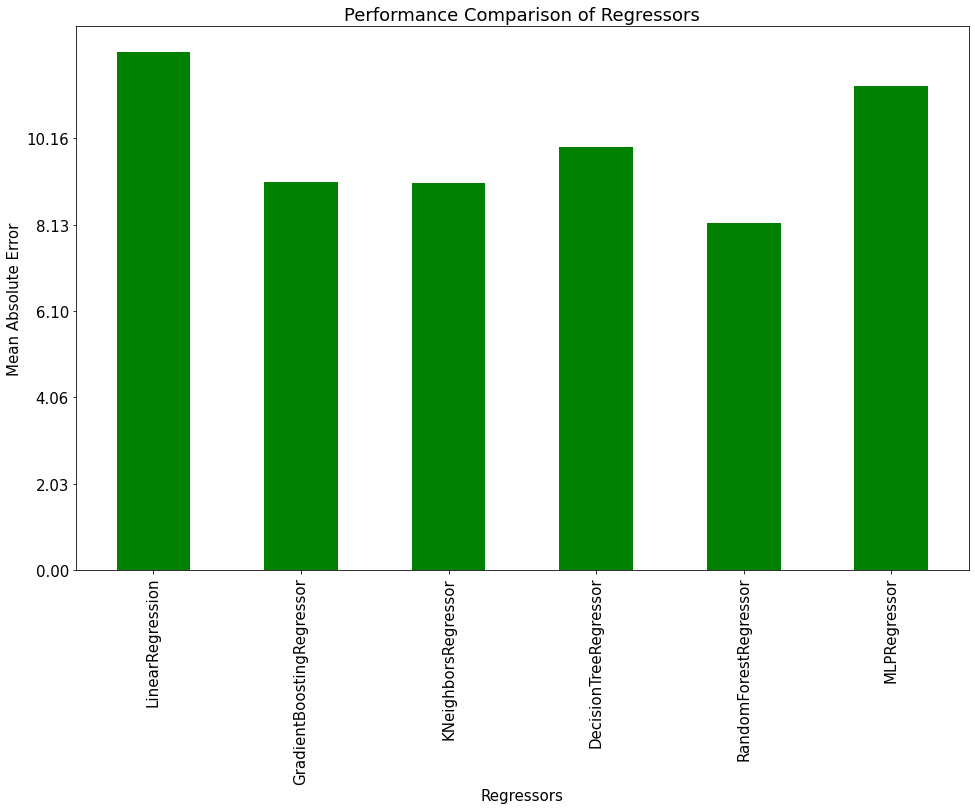

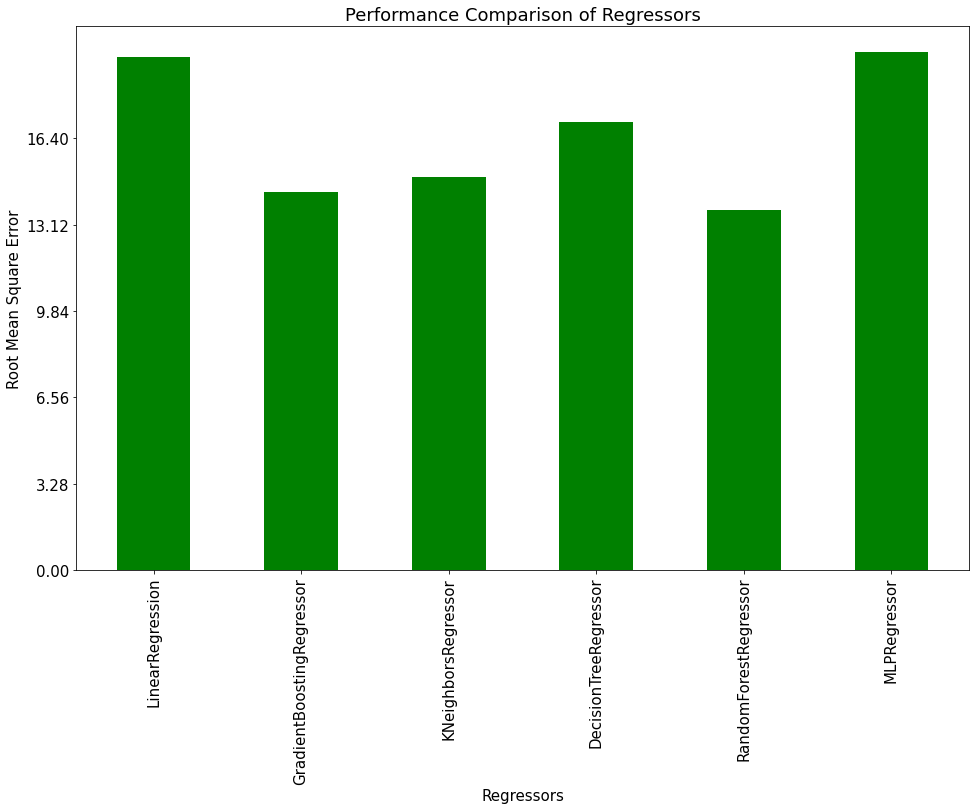

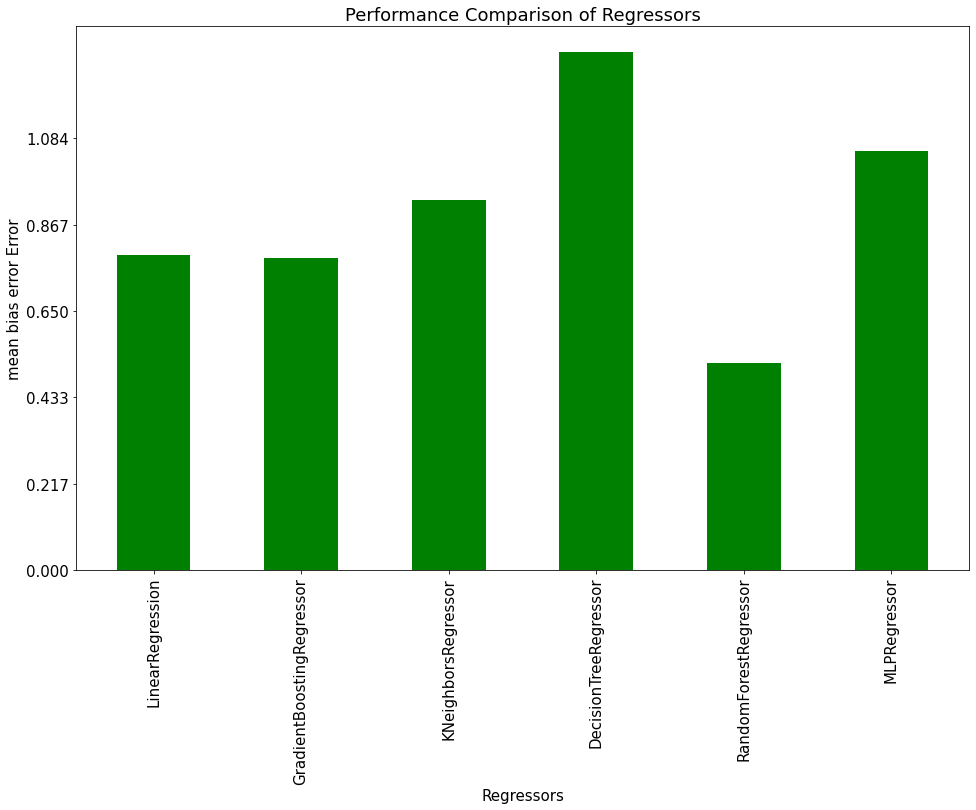

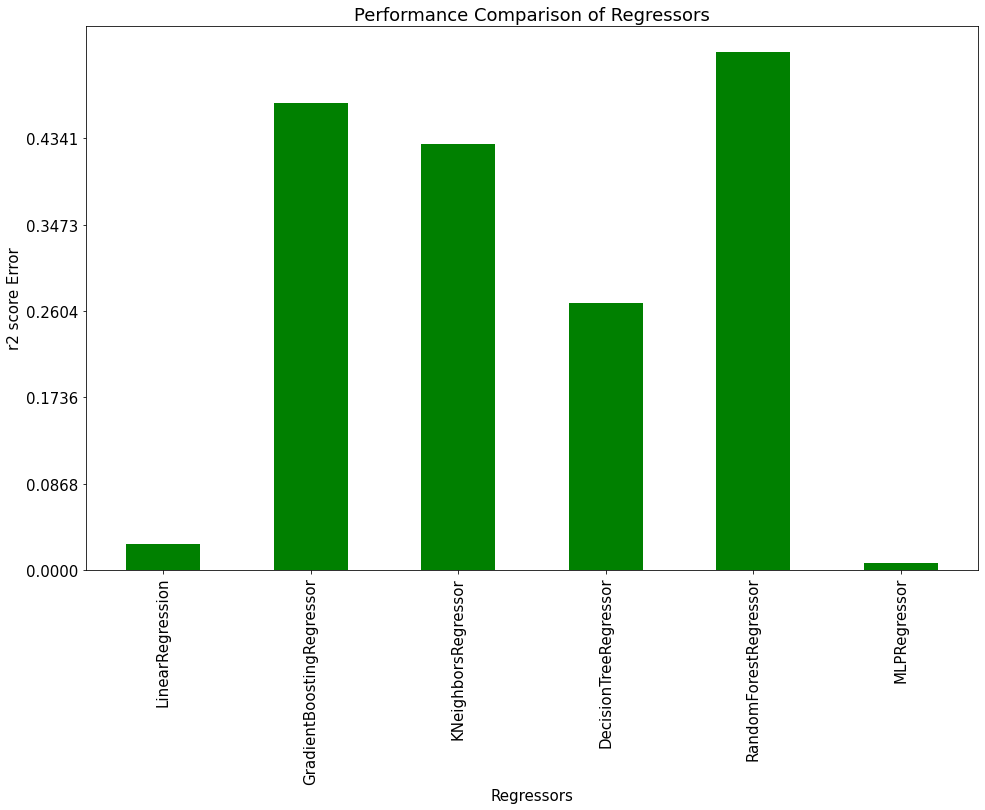

In [32]:
allRegressors(X_train, X_test, y_train, y_test)

************************************************

**************************************************

***********************************************

In [155]:
X_train=data[:1461].drop('PM10', axis = 1).to_numpy()
X_test=data[1461:].drop('PM10', axis = 1).to_numpy()

In [140]:
X_train=data[:1461].drop('PM2.5', axis = 1).to_numpy()
X_test=data[1461:].drop('PM2.5', axis = 1).to_numpy()

In [156]:
y_train=data[:1461]['PM10'].to_numpy()
y_test=data[1461:]['PM10'].to_numpy()

In [141]:
y_train=data[:1461]['PM2.5'].to_numpy()
y_test=data[1461:]['PM2.5'].to_numpy()

In [115]:
X_train

array([[15.28, 25.0, 15.0, 19.04, 55.0],
       [15.28, 23.0, 15.0, 19.04, 34.0],
       [15.28, 22.0, 18.0, 17.0, 47.0],
       ...,
       [10.0, 16.0, 22.0, 18.0, 74.0],
       [10.0, 15.0, 22.0, 24.0, 25.0],
       [10.0, 17.0, 16.58, 18.0, 15.0]], dtype=object)

In [116]:
y_train

array([58.0, 52.6, 52.6, ..., 84.0, 26.0, 24.0], dtype=object)

In [49]:
from itertools import accumulate

In [132]:
length_to_split = [6 for i in range(0,244)]
length_to_split1 = [6 for i in range(0,60)]

In [157]:
Xn_train = [X_train[x - y: x] for x, y in zip(accumulate(length_to_split), length_to_split)]
yn_train = [y_train[x - y: x] for x, y in zip(accumulate(length_to_split), length_to_split)]
Xn_test = [X_test[x - y: x] for x, y in zip(accumulate(length_to_split1), length_to_split1)]
yn_test = [y_test[x - y: x] for x, y in zip(accumulate(length_to_split1), length_to_split1)]


In [119]:
Xn_train

[array([[15.28, 25.0, 15.0, 19.04, 55.0],
        [15.28, 23.0, 15.0, 19.04, 34.0],
        [15.28, 22.0, 18.0, 17.0, 47.0],
        [15.28, 14.0, 20.0, 17.0, 24.0],
        [14.0, 20.0, 17.0, 16.0, 31.0],
        [14.0, 18.0, 18.0, 16.0, 43.0]], dtype=object),
 array([[15.28, 21.0, 20.0, 19.04, 55.0],
        [15.28, 23.0, 18.0, 17.0, 34.0],
        [15.28, 22.0, 18.0, 17.0, 43.0],
        [14.0, 23.0, 18.0, 17.0, 45.0],
        [14.0, 24.0, 19.0, 17.0, 47.0],
        [14.0, 25.0, 19.0, 18.0, 48.0]], dtype=object),
 array([[14.0, 26.0, 19.0, 18.0, 50.0],
        [15.28, 20.0, 20.0, 15.0, 33.0],
        [15.0, 22.0, 17.0, 17.0, 50.57],
        [15.28, 17.0, 23.0, 31.0, 54.0],
        [15.28, 22.0, 21.0, 24.0, 56.0],
        [15.28, 25.0, 21.0, 19.0, 48.0]], dtype=object),
 array([[15.28, 28.0, 17.0, 20.0, 66.0],
        [15.28, 27.0, 18.0, 18.0, 76.0],
        [15.28, 31.0, 15.0, 17.0, 85.0],
        [15.28, 27.0, 17.0, 17.0, 50.57],
        [15.28, 24.0, 17.0, 13.0, 50.57],
        [1

In [120]:
yn_train

[array([58.0, 52.6, 52.6, 52.6, 52.6, 52.6], dtype=object),
 array([52.6, 52.6, 52.6, 52.6, 52.6, 52.6], dtype=object),
 array([52.6, 52.6, 52.6, 52.6, 59.0, 52.6], dtype=object),
 array([63.0, 52.6, 52.6, 52.6, 52.6, 52.6], dtype=object),
 array([69.0, 52.6, 52.6, 52.6, 70.0, 71.0], dtype=object),
 array([72.0, 71.13, 71.13, 71.13, 71.13, 71.13], dtype=object),
 array([65.0, 71.13, 71.13, 71.13, 71.13, 71.13], dtype=object),
 array([71.13, 71.13, 71.13, 71.13, 65.0, 71.13], dtype=object),
 array([71.13, 75.0, 56.0, 71.13, 71.13, 90.0], dtype=object),
 array([71.13, 71.13, 71.13, 71.13, 71.13, 71.13], dtype=object),
 array([71.13, 42.0, 64.62, 64.62, 29.0, 128.0], dtype=object),
 array([95.0, 64.62, 64.62, 45.0, 52.0, 64.62], dtype=object),
 array([64.62, 64.62, 69.0, 47.0, 48.0, 63.0], dtype=object),
 array([58.0, 76.0, 61.0, 64.62, 64.62, 64.62], dtype=object),
 array([42.0, 42.0, 64.62, 64.62, 64.62, 42.0], dtype=object),
 array([64.62, 64.62, 64.62, 67.0, 69.45, 69.45], dtype=objec

In [121]:
Xn_test

[array([[9.0, 14.0, 16.58, 17.0, 30.0],
        [15.28, 17.62, 16.58, 19.04, 50.57],
        [15.28, 17.62, 16.58, 19.04, 50.57],
        [15.28, 17.62, 16.58, 19.04, 50.57],
        [15.28, 17.62, 16.58, 19.04, 50.57],
        [15.28, 17.62, 16.58, 19.04, 50.57]], dtype=object),
 array([[9.0, 17.62, 16.58, 19.0, 59.0],
        [40.0, 19.0, 16.58, 21.0, 30.0],
        [17.0, 19.0, 16.58, 19.0, 52.0],
        [15.0, 17.0, 16.58, 20.0, 50.57],
        [11.0, 12.0, 16.58, 20.0, 69.0],
        [18.0, 17.0, 16.58, 23.0, 78.0]], dtype=object),
 array([[11.0, 17.0, 16.58, 18.0, 57.0],
        [11.0, 21.0, 16.58, 24.0, 43.0],
        [13.0, 18.0, 16.58, 24.0, 35.0],
        [13.0, 17.0, 16.58, 26.0, 36.0],
        [15.0, 12.0, 16.58, 26.0, 106.0],
        [20.0, 16.0, 16.58, 32.0, 76.0]], dtype=object),
 array([[10.0, 16.0, 16.58, 19.0, 80.0],
        [13.0, 16.0, 16.58, 26.0, 65.0],
        [20.0, 16.0, 16.58, 17.0, 64.0],
        [19.0, 15.0, 16.58, 23.0, 54.0],
        [34.0, 17.0, 16.58, 2

In [122]:
yn_test

[array([25.0, 52.6, 52.6, 52.6, 52.6, 52.6], dtype=object),
 array([39.0, 44.0, 45.0, 48.0, 64.0, 74.0], dtype=object),
 array([79.0, 34.0, 54.0, 37.0, 92.0, 74.0], dtype=object),
 array([74.0, 58.0, 57.0, 50.0, 49.0, 50.0], dtype=object),
 array([34.0, 25.0, 41.0, 41.0, 49.0, 55.0], dtype=object),
 array([55.0, 57.0, 70.0, 58.0, 49.0, 57.0], dtype=object),
 array([63.0, 70.0, 53.0, 54.0, 48.0, 52.0], dtype=object),
 array([39.0, 29.0, 24.0, 58.0, 64.0, 60.0], dtype=object),
 array([67.0, 54.0, 56.0, 67.0, 59.0, 71.13], dtype=object),
 array([71.13, 39.0, 71.13, 69.0, 58.0, 34.0], dtype=object),
 array([34.0, 44.0, 65.0, 53.0, 67.0, 55.0], dtype=object),
 array([46.0, 50.0, 44.0, 74.0, 36.0, 46.0], dtype=object),
 array([43.0, 31.0, 52.0, 63.0, 46.0, 40.0], dtype=object),
 array([45.0, 64.62, 64.62, 64.62, 64.62, 64.62], dtype=object),
 array([46.0, 39.0, 67.0, 90.0, 71.0, 72.0], dtype=object),
 array([86.0, 64.0, 62.0, 55.0, 41.0, 38.0], dtype=object),
 array([41.0, 47.0, 60.0, 69.0, 

In [158]:
X_trainl=Xn_train[:-1]
X_testl=Xn_test
y_trainl=yn_train[:-1]
y_testl=yn_test

In [74]:
from keras.models import Sequential
from keras.layers import Input, CuDNNLSTM, Dense
import keras.backend as K

In [124]:
tf.convert_to_tensor(X_trainl)

ValueError: ignored

In [152]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Model configuration
additional_metrics = ['accuracy']
batch_size = 128
embedding_output_dims = 15
loss_function = BinaryCrossentropy()
max_sequence_length = 300
num_distinct_words = 5000
number_of_epochs = 5
optimizer = Adam()
validation_split = 0.20
verbosity_mode = 1

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Load dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_distinct_words)
print(x_train.shape)
print(x_test.shape)

# Pad all sequences
padded_inputs = pad_sequences(x_train, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>
padded_inputs_test = pad_sequences(x_test, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>
padded_inputs
# Define the Keras model
model = Sequential()
model.add(tf.keras.layers.Dense(8, input_shape=( 6,5)))
model.add(LSTM(10))
model.add(Dense(6))

# Compile the model
model.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='categorical_crossentropy',metrics=['accuracy'])

# Give a summary
model.summary()

# Train the model
history = model.fit(np.array(X_trainl), np.array(y_trainl), batch_size=batch_size, epochs=500, verbose=verbosity_mode, validation_split=validation_split)

# Test the model after training
test_results = model.evaluate(np.array(X_testl), np.array(y_testl), verbose=False)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')

(25000,)
(25000,)
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_59 (Dense)            (None, 6, 8)              48        
                                                                 
 lstm_25 (LSTM)              (None, 10)                760       
                                                                 
 dense_60 (Dense)            (None, 6)                 66        
                                                                 
Total params: 874
Trainable params: 874
Non-trainable params: 0
_________________________________________________________________
Train on 194 samples, validate on 49 samples
Epoch 1/500
194/194 [==============================] - 2s 12ms/sample - loss: 3326.5936 - accuracy: 0.1289 - val_loss: 2774.5779 - val_accuracy: 0.1429
Epoch 2/500
194/194 [==============================] - 0s 131us/sample - loss: 3070.2268 - accuracy: 0.1

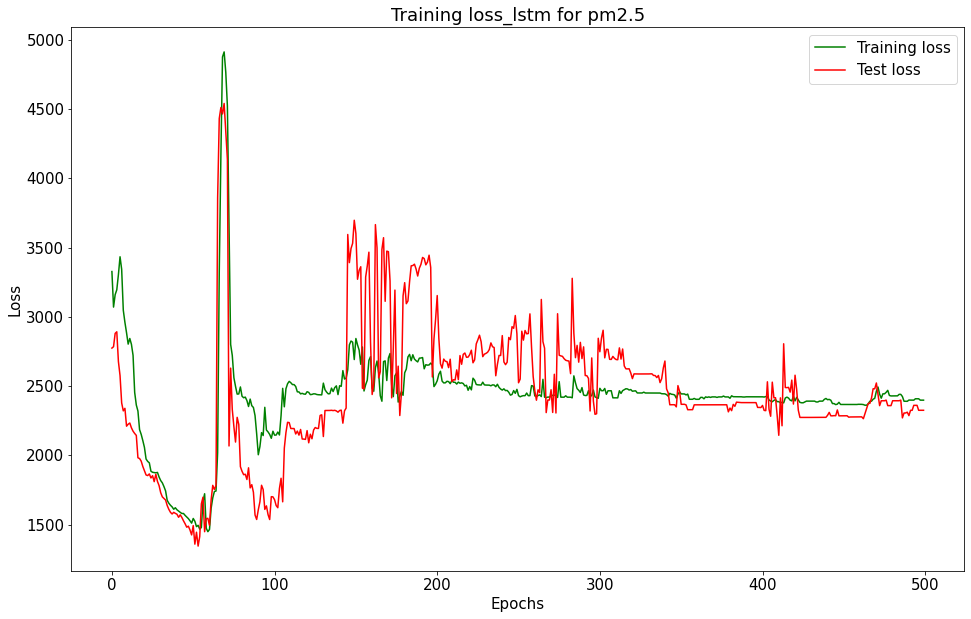

In [153]:
plt.plot(history.epoch, history.history["loss"], 'g', label='Training loss')
plt.plot(history.epoch, history.history["val_loss"], 'r', label='Test loss')
plt.title('Training loss_lstm for pm2.5')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

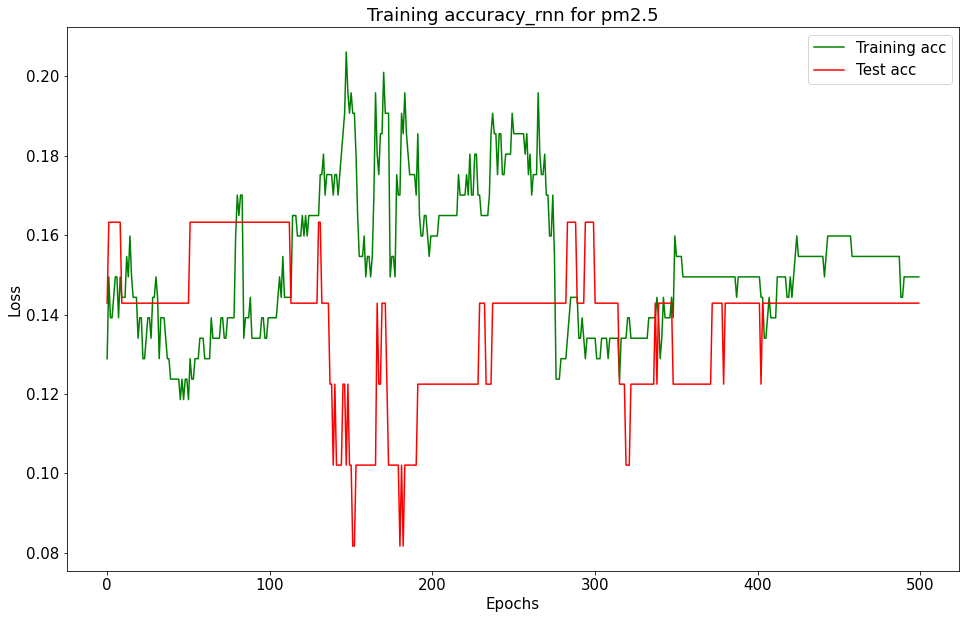

In [154]:
plt.plot(history.epoch, history.history["accuracy"], 'g', label='Training acc')
plt.plot(history.epoch, history.history["val_accuracy"], 'r', label='Test acc')
plt.title('Training accuracy_lstm for pm2.5')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [159]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Model configuration
additional_metrics = ['accuracy']
batch_size = 128
embedding_output_dims = 15
loss_function = BinaryCrossentropy()
max_sequence_length = 300
num_distinct_words = 5000
number_of_epochs = 5
optimizer = Adam()
validation_split = 0.20
verbosity_mode = 1

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Load dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_distinct_words)
print(x_train.shape)
print(x_test.shape)

# Pad all sequences
padded_inputs = pad_sequences(x_train, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>
padded_inputs_test = pad_sequences(x_test, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>
padded_inputs
# Define the Keras model
model = Sequential()
model.add(tf.keras.layers.Dense(8, input_shape=( 6,5)))
model.add(LSTM(10))
model.add(Dense(6))

# Compile the model
model.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='categorical_crossentropy',metrics=['accuracy'])

# Give a summary
model.summary()

# Train the model
history = model.fit(np.array(X_trainl), np.array(y_trainl), batch_size=batch_size, epochs=500, verbose=verbosity_mode, validation_split=validation_split)

# Test the model after training
test_results = model.evaluate(np.array(X_testl), np.array(y_testl), verbose=False)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')

(25000,)
(25000,)
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_61 (Dense)            (None, 6, 8)              48        
                                                                 
 lstm_26 (LSTM)              (None, 10)                760       
                                                                 
 dense_62 (Dense)            (None, 6)                 66        
                                                                 
Total params: 874
Trainable params: 874
Non-trainable params: 0
_________________________________________________________________
Train on 194 samples, validate on 49 samples
Epoch 1/500
194/194 [==============================] - 7s 34ms/sample - loss: 2224.5031 - accuracy: 0.2938 - val_loss: 2250.1807 - val_accuracy: 0.2041
Epoch 2/500
194/194 [==============================] - 0s 240us/sample - loss: 2160.1658 - accuracy: 0.2

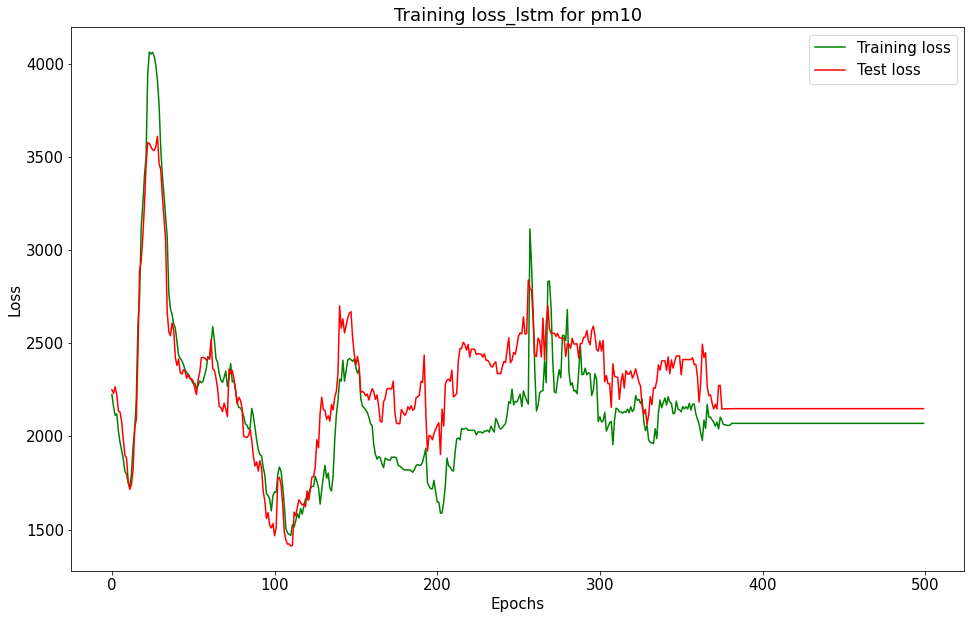

In [160]:
plt.plot(history.epoch, history.history["loss"], 'g', label='Training loss')
plt.plot(history.epoch, history.history["val_loss"], 'r', label='Test loss')
plt.title('Training loss_lstm for pm10')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

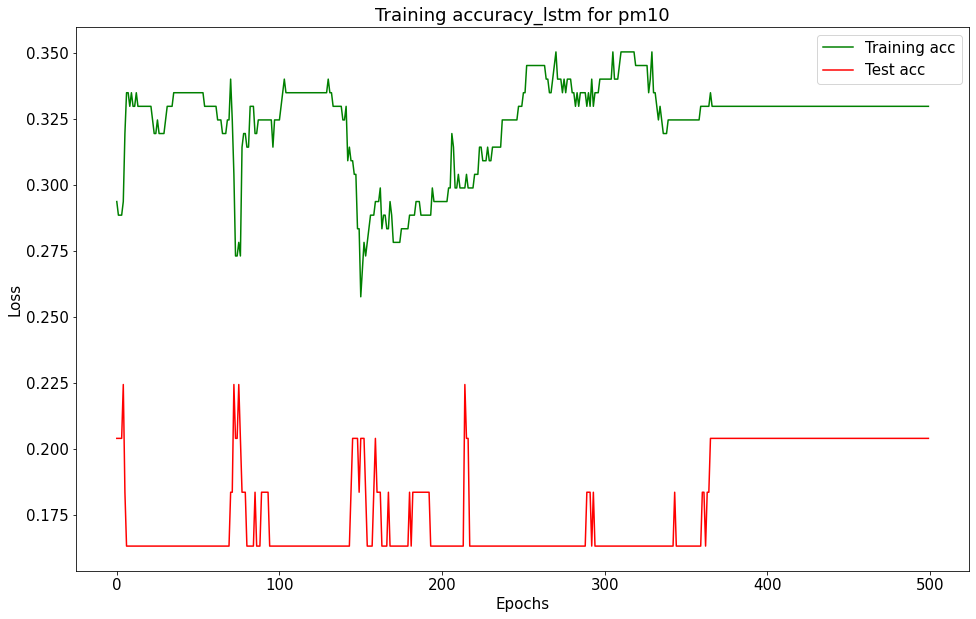

In [161]:
plt.plot(history.epoch, history.history["accuracy"], 'g', label='Training acc')
plt.plot(history.epoch, history.history["val_accuracy"], 'r', label='Test acc')
plt.title('Training accuracy_lstm for pm10')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [162]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Dense, LSTM, SimpleRNN
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Model configuration
additional_metrics = ['accuracy']
batch_size = 128
embedding_output_dims = 15
loss_function = BinaryCrossentropy()
max_sequence_length = 300
num_distinct_words = 5000
number_of_epochs = 5
optimizer = Adam()
validation_split = 0.20
verbosity_mode = 1

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Load dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_distinct_words)
print(x_train.shape)
print(x_test.shape)

# Pad all sequences
padded_inputs = pad_sequences(x_train, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>
padded_inputs_test = pad_sequences(x_test, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>
padded_inputs
# Define the Keras model
model = Sequential()
model.add(tf.keras.layers.Dense(8, input_shape=( 6,5)))
model.add(SimpleRNN(10))
model.add(Dense(6))

# Compile the model
model.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='categorical_crossentropy',metrics=['accuracy'])

# Give a summary
model.summary()

# Train the model
history = model.fit(np.array(X_trainl), np.array(y_trainl), batch_size=batch_size, epochs=500, verbose=verbosity_mode, validation_split=validation_split)

# Test the model after training
test_results = model.evaluate(np.array(X_testl), np.array(y_testl), verbose=False)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')

(25000,)
(25000,)
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 6, 8)              48        
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 10)                190       
                                                                 
 dense_64 (Dense)            (None, 6)                 66        
                                                                 
Total params: 304
Trainable params: 304
Non-trainable params: 0
_________________________________________________________________
Train on 194 samples, validate on 49 samples
Epoch 1/500
194/194 [==============================] - 3s 13ms/sample - loss: 2572.8427 - accuracy: 0.2887 - val_loss: 2744.6519 - val_accuracy: 0.1020
Epoch 2/500
194/194 [==============================] - 0s 124us/sample - loss: 2566.2101 - accuracy: 0.2

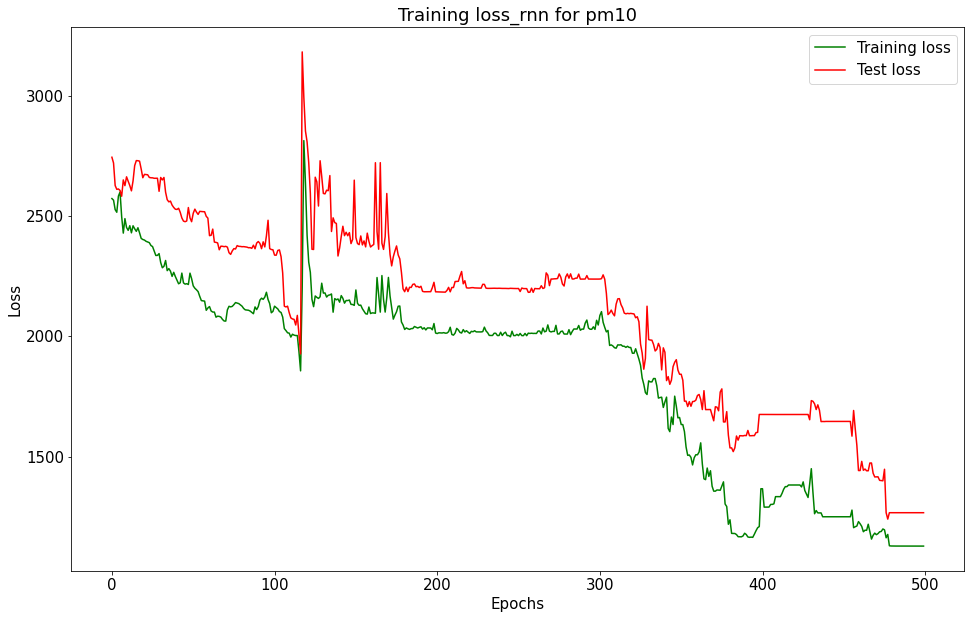

In [163]:
plt.plot(history.epoch, history.history["loss"], 'g', label='Training loss')
plt.plot(history.epoch, history.history["val_loss"], 'r', label='Test loss')
plt.title('Training loss_rnn for pm10')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

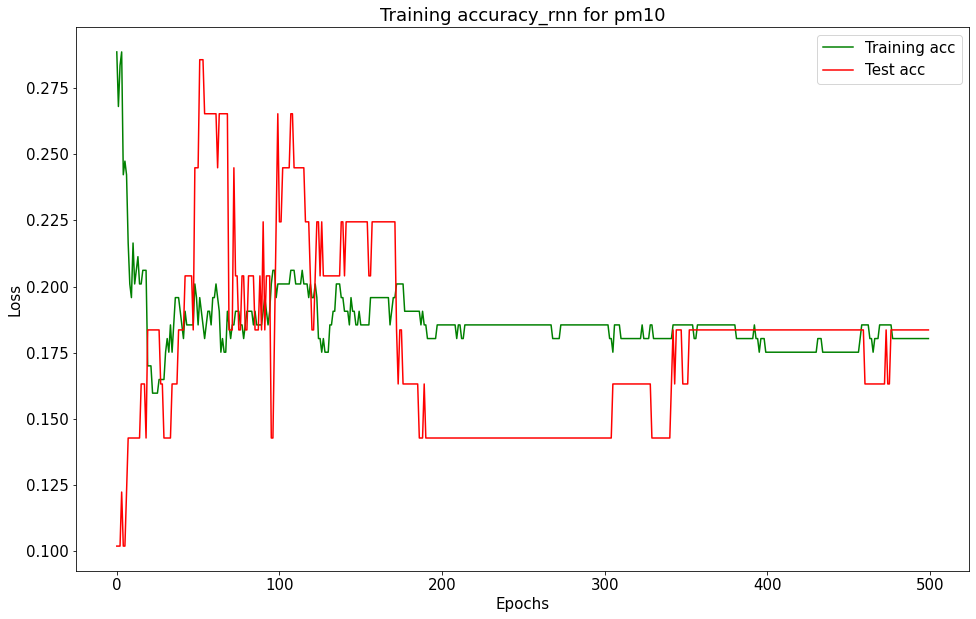

In [164]:
plt.plot(history.epoch, history.history["accuracy"], 'g', label='Training acc')
plt.plot(history.epoch, history.history["val_accuracy"], 'r', label='Test acc')
plt.title('Training accuracy_rnn for pm10')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [147]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Dense, LSTM, SimpleRNN
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Model configuration
additional_metrics = ['accuracy']
batch_size = 128
embedding_output_dims = 15
loss_function = BinaryCrossentropy()
max_sequence_length = 300
num_distinct_words = 5000
number_of_epochs = 5
optimizer = Adam()
validation_split = 0.20
verbosity_mode = 1

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Load dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_distinct_words)
print(x_train.shape)
print(x_test.shape)

# Pad all sequences
padded_inputs = pad_sequences(x_train, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>
padded_inputs_test = pad_sequences(x_test, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>
padded_inputs
# Define the Keras model
model = Sequential()
model.add(tf.keras.layers.Dense(8, input_shape=( 6,5)))
model.add(SimpleRNN(10))
model.add(Dense(6))

# Compile the model
model.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='categorical_crossentropy',metrics=['accuracy'])

# Give a summary
model.summary()

# Train the model
history = model.fit(np.array(X_trainl), np.array(y_trainl), batch_size=batch_size, epochs=500, verbose=verbosity_mode, validation_split=validation_split)

# Test the model after training
test_results = model.evaluate(np.array(X_testl), np.array(y_testl), verbose=False)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')

(25000,)
(25000,)
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 6, 8)              48        
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 10)                190       
                                                                 
 dense_58 (Dense)            (None, 6)                 66        
                                                                 
Total params: 304
Trainable params: 304
Non-trainable params: 0
_________________________________________________________________
Train on 194 samples, validate on 49 samples
Epoch 1/500
194/194 [==============================] - 3s 14ms/sample - loss: 2553.1732 - accuracy: 0.1392 - val_loss: 2563.3528 - val_accuracy: 0.2245
Epoch 2/500
194/194 [==============================] - 0s 112us/sample - loss: 2650.2592 - accuracy: 0.1

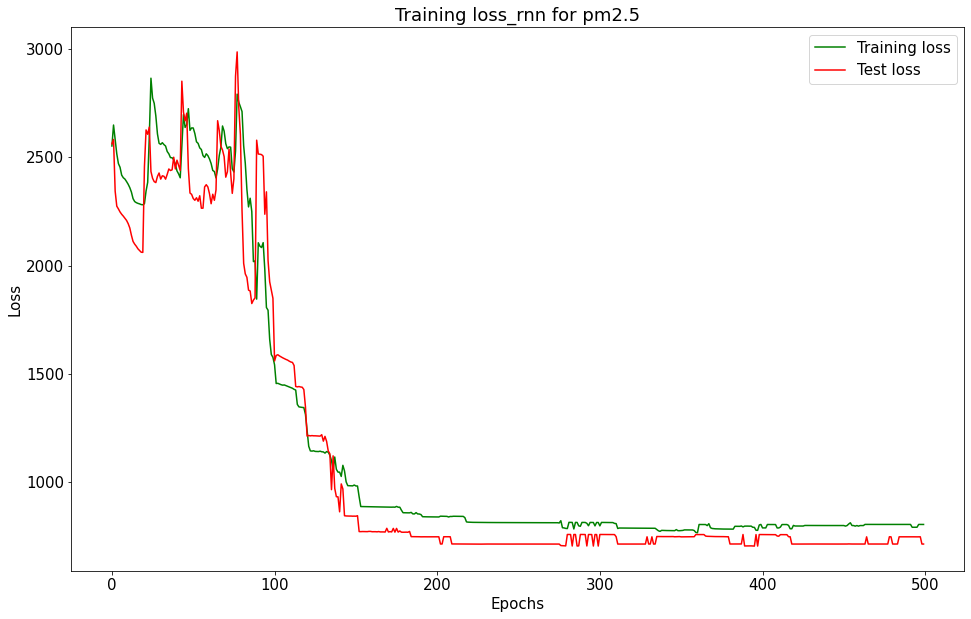

In [148]:
plt.plot(history.epoch, history.history["loss"], 'g', label='Training loss')
plt.plot(history.epoch, history.history["val_loss"], 'r', label='Test loss')
plt.title('Training loss_rnn for pm2.5')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

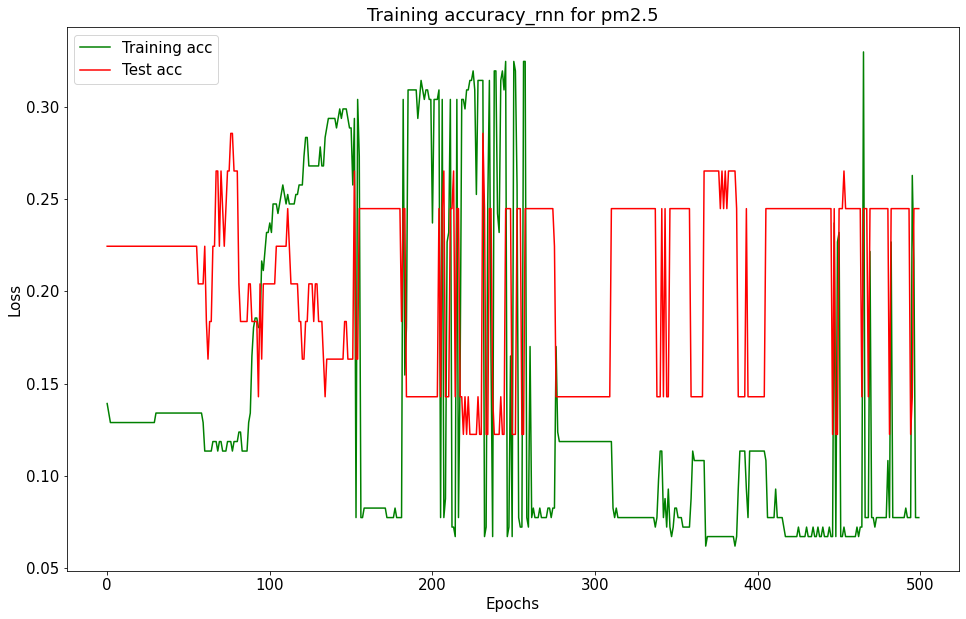

In [151]:
plt.plot(history.epoch, history.history["accuracy"], 'g', label='Training acc')
plt.plot(history.epoch, history.history["val_accuracy"], 'r', label='Test acc')
plt.title('Training accuracy_rnn for pm2.5')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

statistic

In [187]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import glob
import statistics

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [188]:
# read data
filePath = '/content/bitaData(1).csv'

data = pd.read_csv(filePath)
data

,date,year,month,day,co,o3,no2,so2,pm10,pm2.5
0,1396-01-01,1396,1,1,0,25,15,0,55.0,58.0
1,1396-01-02,1396,1,2,0,23,15,0,34.0,0.0
2,1396-01-03,1396,1,3,0,22,18,17,47.0,0.0
3,1396-01-04,1396,1,4,0,14,20,17,24.0,0.0
4,1396-01-05,1396,1,5,14,20,17,16,31.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1820,1400-12-25,1400,12,25,7,24,11,19,84.0,93.0
1821,1400-12-26,1400,12,26,6,25,11,18,27.0,41.0
1822,1400-12-27,1400,12,27,5,26,11,19,20.0,33.0
1823,1400-12-28,1400,12,28,7,25,11,17,36.0,39.0


In [189]:
data.replace(to_replace = 0, value = pd.NA, inplace=True)

In [190]:
# check the null data
data.isnull().sum()

date       0
year       0
month      0
day        0
co       367
o3       165
no2      561
so2      270
pm10     424
pm2.5    480
dtype: int64

In [191]:
# drop the row no column and rename the columns
#data.drop(["date"], axis=1, inplace=True)
data.rename(columns = {'year': 'Year',
                       'month': 'Month',
                       "day":"Day",
                       "date":"Date",
                       'co': "CO",
                       'o3': 'O3',
                       'pm2.5': 'PM2.5',
                       'pm10': 'PM10',
                       'no2': 'NO2',
                       'so2': 'SO2',
                       }, inplace = True)
data

,Date,Year,Month,Day,CO,O3,NO2,SO2,PM10,PM2.5
0,1396-01-01,1396,1,1,<NA>,25,15,<NA>,55.0,58.0
1,1396-01-02,1396,1,2,<NA>,23,15,<NA>,34.0,<NA>
2,1396-01-03,1396,1,3,<NA>,22,18,17,47.0,<NA>
3,1396-01-04,1396,1,4,<NA>,14,20,17,24.0,<NA>
4,1396-01-05,1396,1,5,14,20,17,16,31.0,<NA>
...,...,...,...,...,...,...,...,...,...,...
1820,1400-12-25,1400,12,25,7,24,11,19,84.0,93.0
1821,1400-12-26,1400,12,26,6,25,11,18,27.0,41.0
1822,1400-12-27,1400,12,27,5,26,11,19,20.0,33.0
1823,1400-12-28,1400,12,28,7,25,11,17,36.0,39.0


In [192]:
# fill the null values in numerical columns with average specific to certain column
# fill in the missing data in the columns according to the Month average.
unique_Month = pd.unique(data.Month)

# find PM2_5 averages in Month specific
# Equalize the average PM2.5 values to the missing values in PM2_5 specific to Month
temp_data = data.copy()  # set temp_data variable to avoid losing real data
columns = ["CO" ,	"O3", 	"NO2", 	"SO2" ,	"PM10" ,	"PM2.5"] # it can be add more column
for c in unique_Month:
    
    # create Month filter
    Month_filtre = temp_data.Month == c
    # filter data by Month
    fitered_data = temp_data[Month_filtre]
    
    # find average for PM2_5 in specific to Month
    for s in columns:
        mean = np.round(np.mean(fitered_data[s]), 2)
        if ~np.isnan(mean): # if there if average specific to Month
            fitered_data[s] = fitered_data[s].fillna(mean)
            print(f"Missing Value in {s} column fill with {mean} when Month:{c}")
        else: # find average for all data if no average in specific to Month
            all_data_mean = np.round(np.mean(data[s]),2)
            fitered_data[s] = fitered_data[s].fillna(all_data_mean)
            print(f"Missing Value in {s} column fill with {all_data_mean}")
    # Synchronize data filled with missing values in PM2.5 to data temporary            
    temp_data[Month_filtre] = fitered_data

# equate the deprecated temporary data to the real data variable
data = temp_data.copy() 

Missing Value in CO column fill with 15.28 when Month:1
Missing Value in O3 column fill with 17.62 when Month:1
Missing Value in NO2 column fill with 16.58 when Month:1
Missing Value in SO2 column fill with 19.04 when Month:1
Missing Value in PM10 column fill with 50.57 when Month:1
Missing Value in PM2.5 column fill with 52.6 when Month:1
Missing Value in CO column fill with 16.28 when Month:2
Missing Value in O3 column fill with 19.05 when Month:2
Missing Value in NO2 column fill with 23.55 when Month:2
Missing Value in SO2 column fill with 20.41 when Month:2
Missing Value in PM10 column fill with 56.29 when Month:2
Missing Value in PM2.5 column fill with 71.13 when Month:2
Missing Value in CO column fill with 14.93 when Month:3
Missing Value in O3 column fill with 22.42 when Month:3
Missing Value in NO2 column fill with 18.1 when Month:3
Missing Value in SO2 column fill with 21.98 when Month:3
Missing Value in PM10 column fill with 61.66 when Month:3
Missing Value in PM2.5 column fi

In [195]:
# information about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1825 non-null   object 
 1   Year    1825 non-null   int64  
 2   Month   1825 non-null   int64  
 3   Day     1825 non-null   int64  
 4   CO      1825 non-null   float64
 5   O3      1825 non-null   float64
 6   NO2     1825 non-null   float64
 7   SO2     1825 non-null   float64
 8   PM10    1825 non-null   float64
 9   PM2.5   1825 non-null   float64
dtypes: float64(6), int64(3), object(1)
memory usage: 142.7+ KB


In [194]:
data=data.astype({"CO":"float","O3":"float","NO2":"float","SO2":"float","PM2.5":"float","PM10":"float"})

In [196]:
# check the null data
data.isnull().sum()

Date     0
Year     0
Month    0
Day      0
CO       0
O3       0
NO2      0
SO2      0
PM10     0
PM2.5    0
dtype: int64

In [197]:
# statistical information about data
data.drop(["Year", "Month", "Day" ,"Date"], axis=1).describe()

,CO,O3,NO2,SO2,PM10,PM2.5
count,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,20.309304,21.572389,20.351764,24.622247,61.242307,67.501337
std,16.266728,11.889640,10.322276,9.472616,20.149432,24.550381
min,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000
25%,12.000000,14.000000,16.000000,18.000000,53.000000,55.000000
50%,17.000000,19.000000,18.210000,23.000000,61.000000,67.000000
75%,26.000000,26.150000,23.550000,29.000000,69.000000,76.720000
max,500.000000,152.000000,87.000000,110.000000,374.000000,462.000000


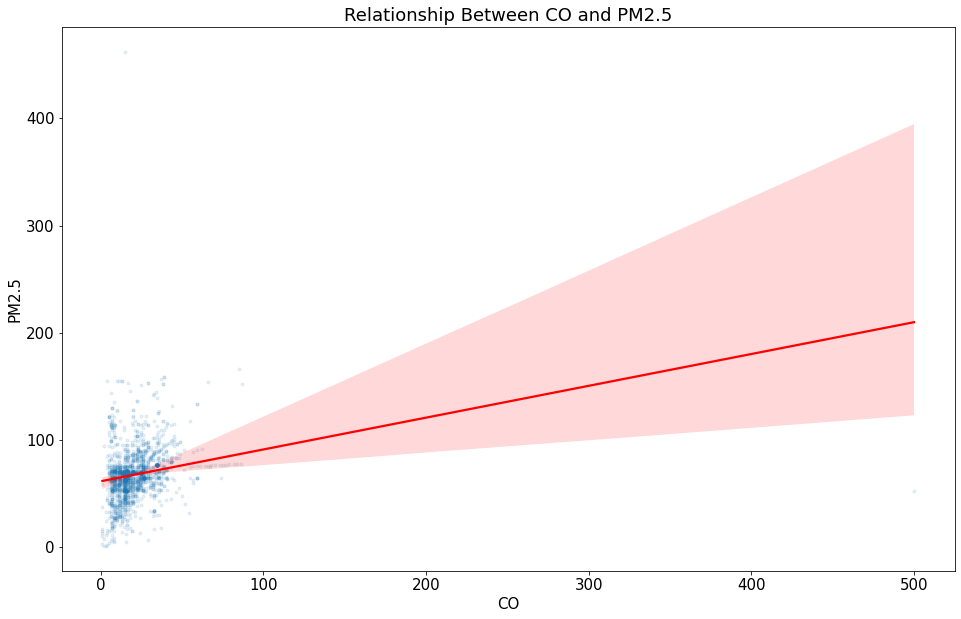

In [198]:
sns.regplot(x='CO', y='PM2.5', data=data, marker=".", scatter_kws={'alpha':0.1}, line_kws={'color':"r"})
plt.title('Relationship Between CO and PM2.5')
plt.show()

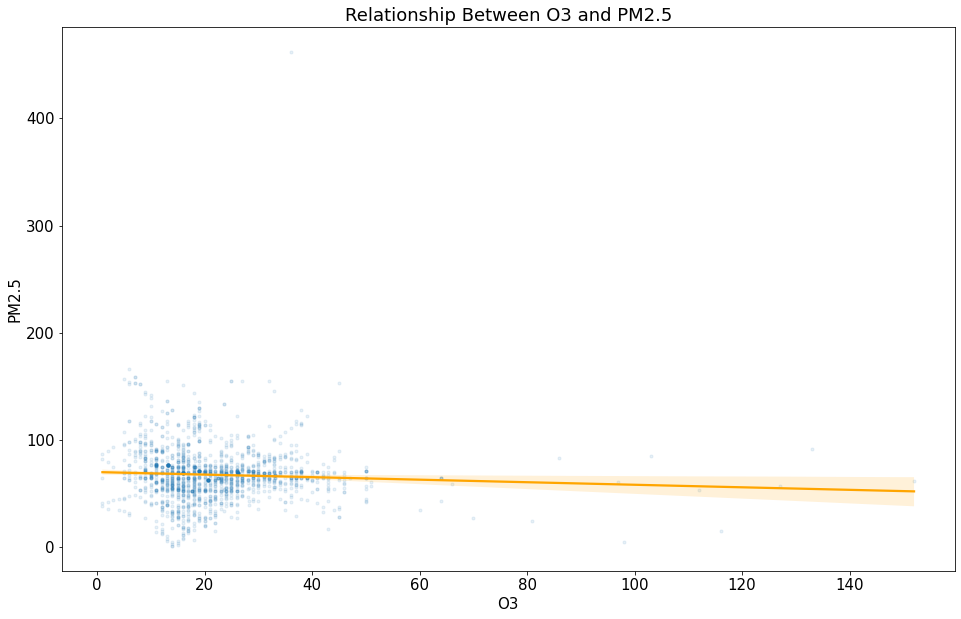

In [199]:
sns.regplot(x='O3', y='PM2.5', data=data, marker=".", scatter_kws={'alpha':0.1}, line_kws={'color':"orange"})
plt.title('Relationship Between O3 and PM2.5')
plt.show()

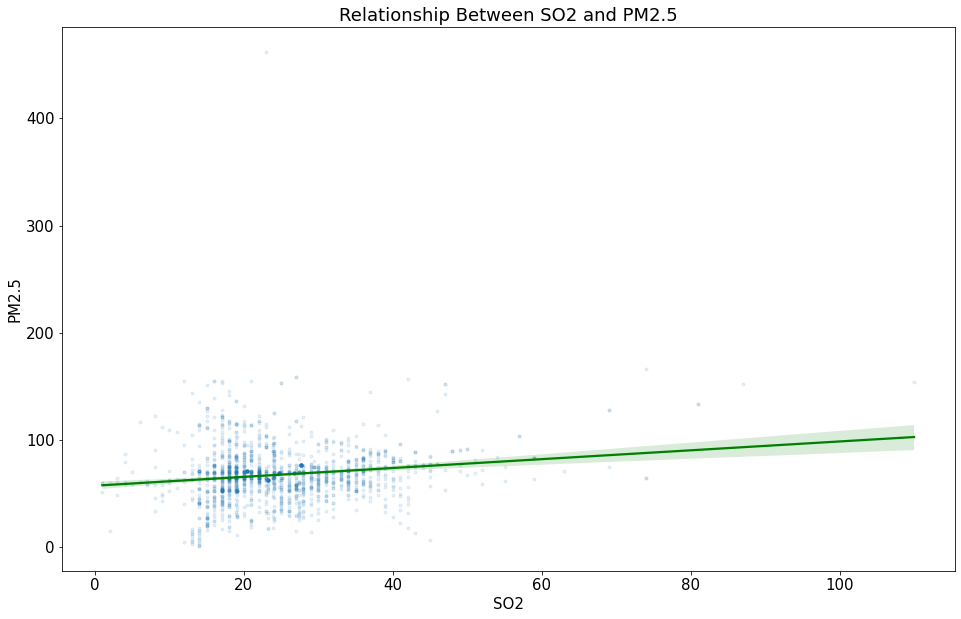

In [200]:
sns.regplot(x='SO2', y='PM2.5', data=data, marker=".", scatter_kws={'alpha':0.1}, line_kws={'color':"green"})
plt.title('Relationship Between SO2 and PM2.5')
plt.show()

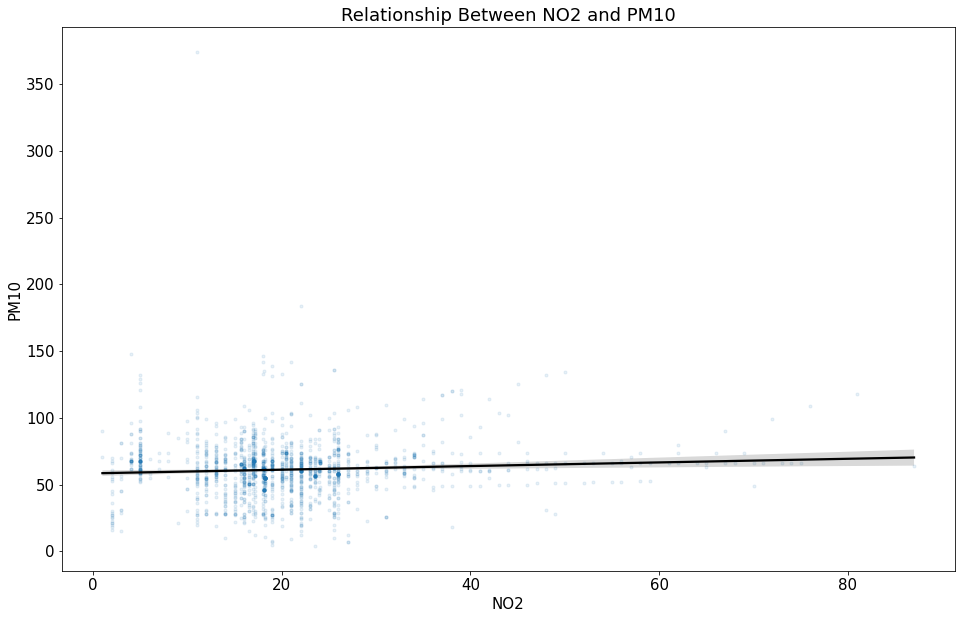

In [201]:
sns.regplot(x='NO2', y='PM10', data=data, marker=".", scatter_kws={'alpha':0.1}, line_kws={'color':"black"})
plt.title('Relationship Between NO2 and PM10')
plt.show()

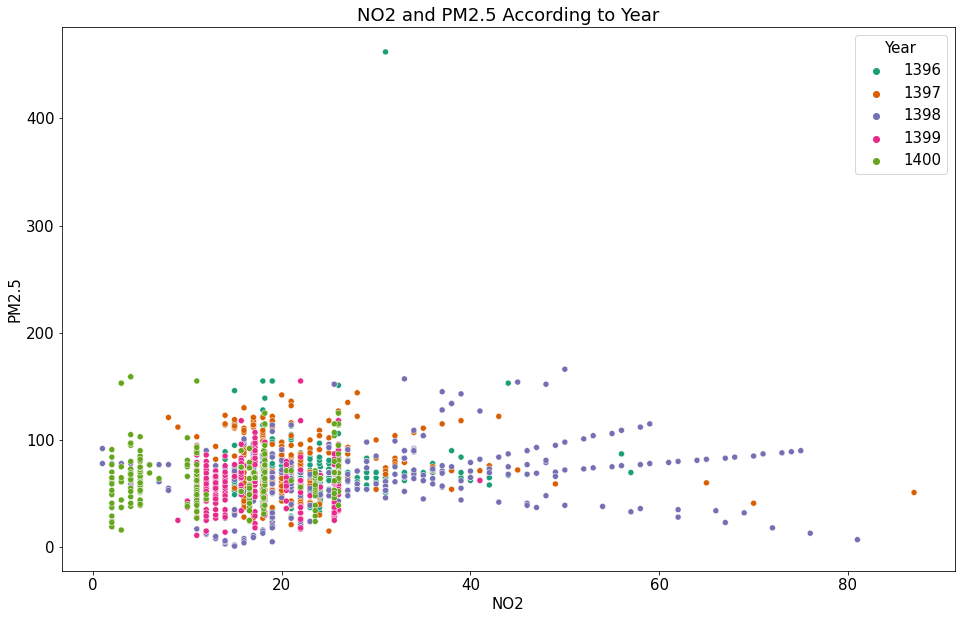

In [202]:
sns.scatterplot(x='NO2', y='PM2.5', hue='Year', data=data, palette = "Dark2")
plt.title('NO2 and PM2.5 According to Year')
plt.show()

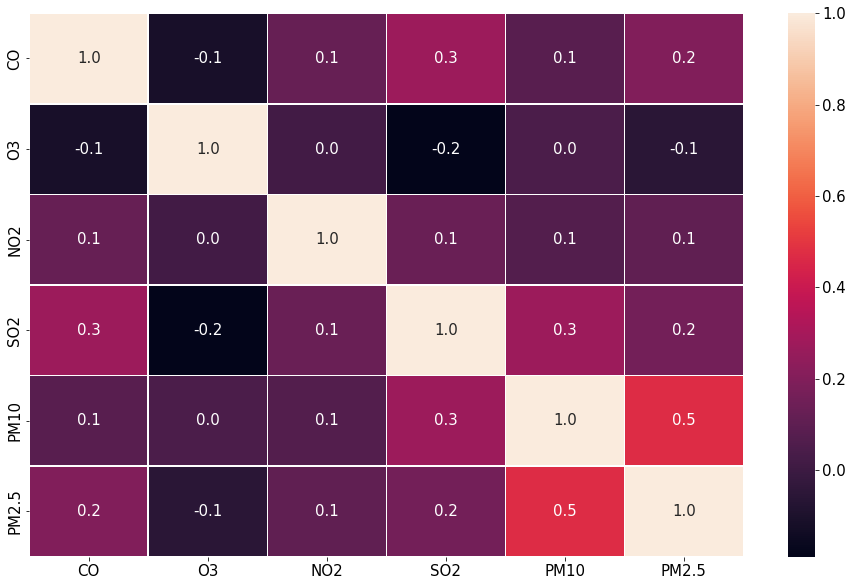

In [203]:
sns.heatmap(data.drop(["Year", "Month", "Day", "Date"], axis=1).corr(),
            annot=True, linewidths=.5, fmt= '.1f')
plt.show()

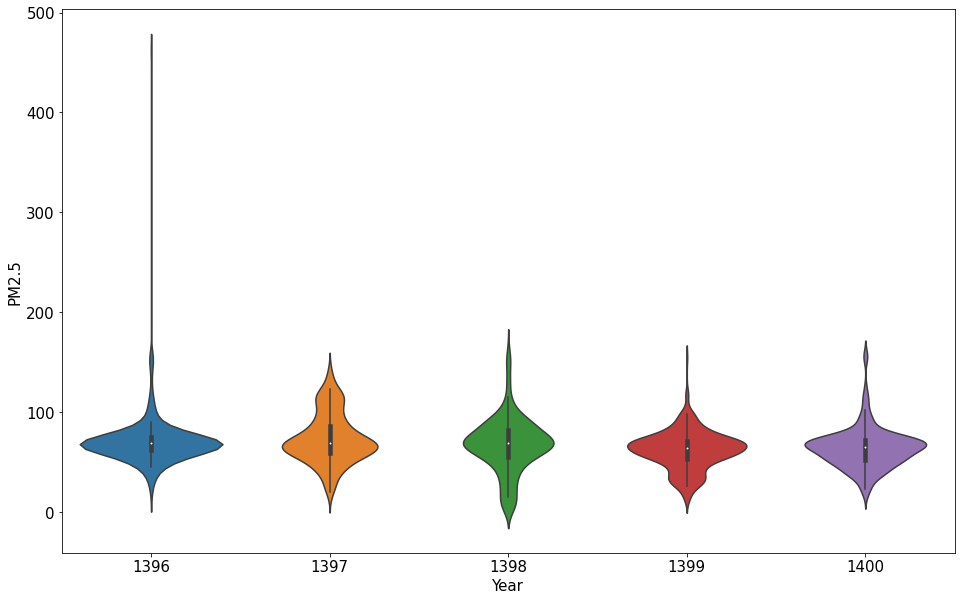

In [204]:
sns.violinplot(x="Year", y="PM2.5", data=data)
plt.show()

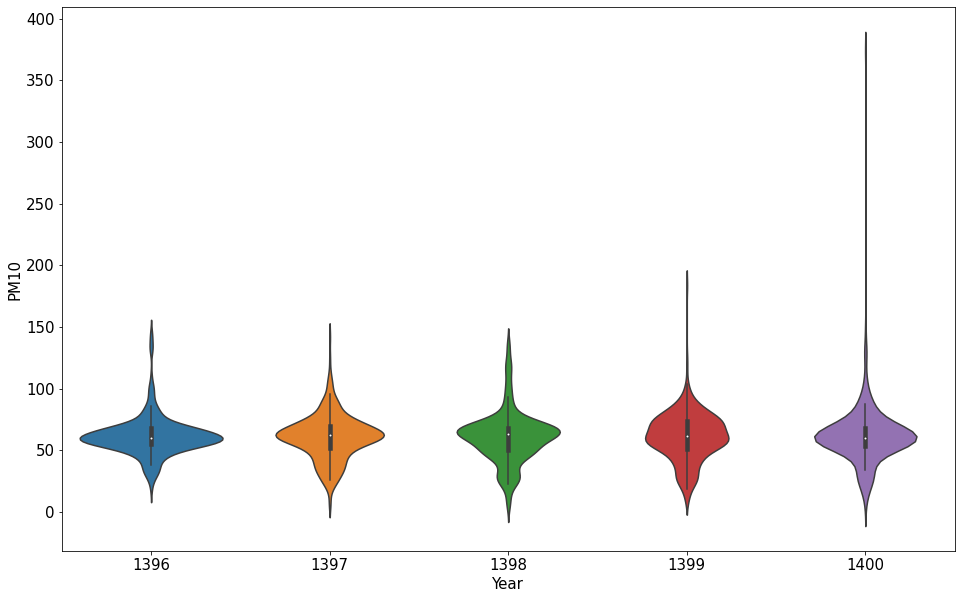

In [205]:
sns.violinplot(x="Year", y="PM10", data=data)
plt.show()

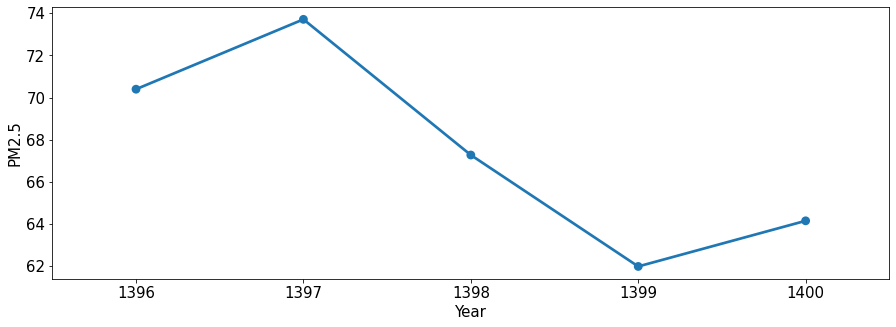

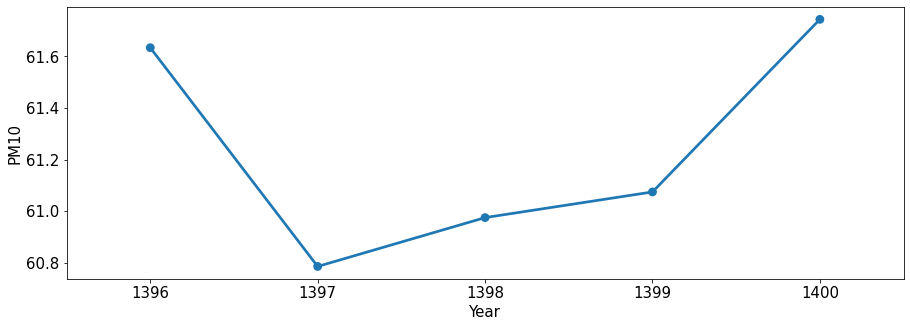

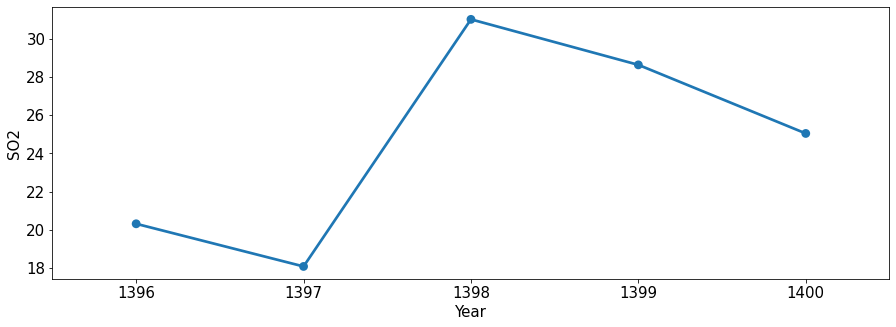

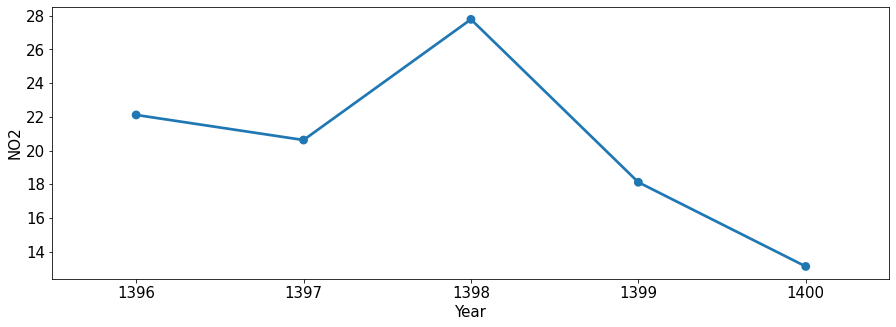

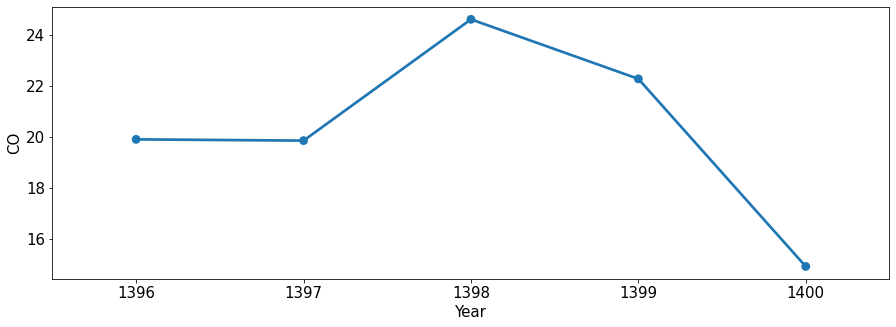

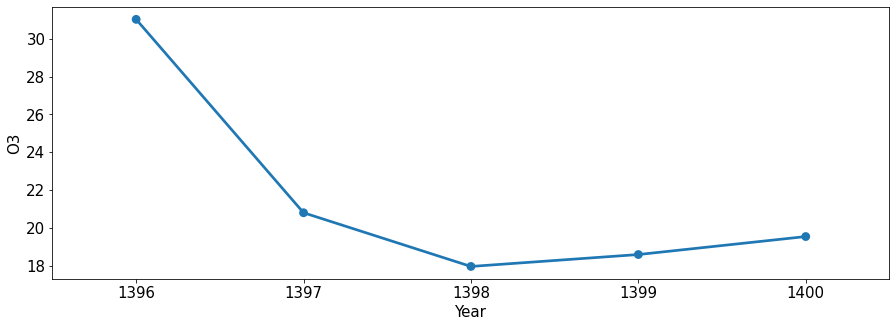

In [206]:
compounds = ["PM2.5", "PM10", "SO2", "NO2", "CO", "O3"]
for i in compounds:    
    df = data[[i, 'Year']].groupby(["Year"]).mean().reset_index().sort_values(by='Year', ascending=False)
    f, ax=plt.subplots(figsize=(15, 5))
    sns.pointplot(x='Year', y=i, data=df)

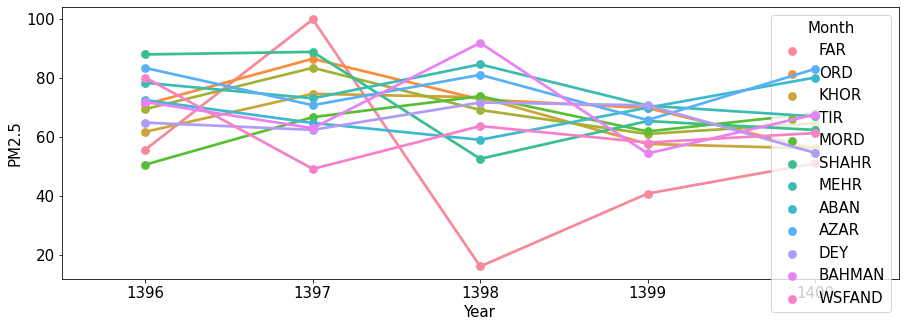

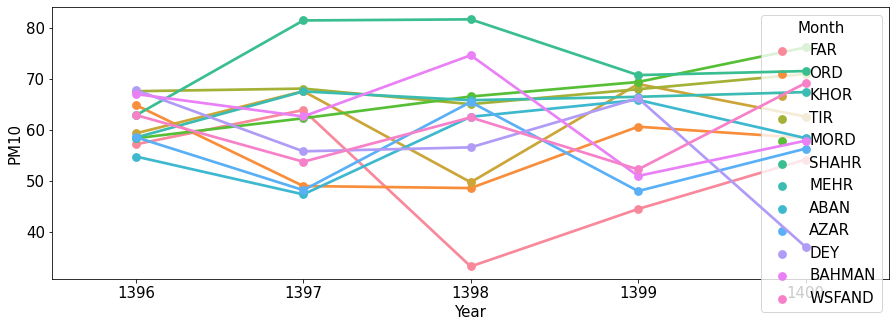

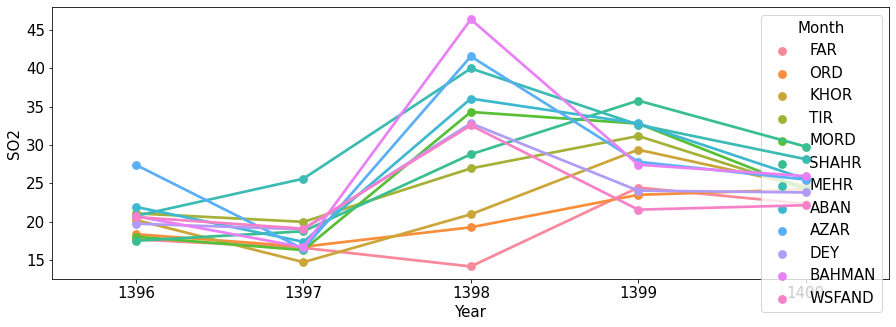

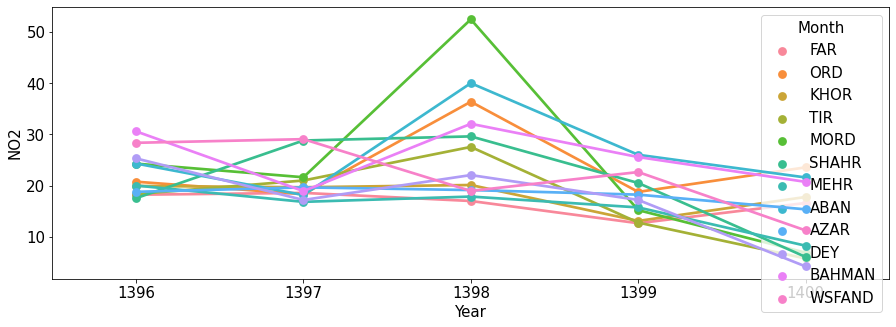

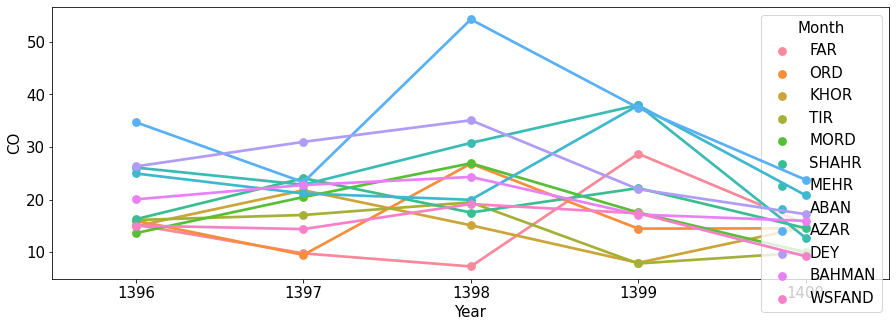

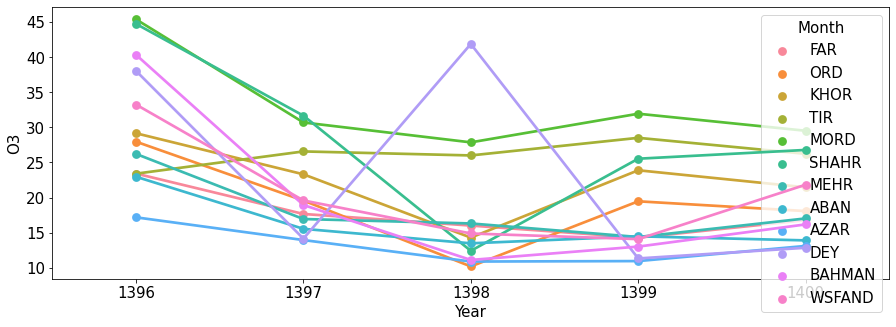

In [208]:
for i in compounds:
    temp_data = data.copy()
    temp_data.Month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['FAR', 'ORD', 'KHOR', 'TIR', 'MORD', 
                                                           'SHAHR', 'MEHR', 'ABAN', 'AZAR', 'DEY', 'BAHMAN', 'WSFAND'], inplace=True)
    df = temp_data[[i, 'Month', 'Year',]].groupby(["Year",
                                                    "Month"]).mean().reset_index().sort_values(by=['Year',
                                                                                                   'Month'], ascending=False)
    f, ax=plt.subplots(figsize=(15, 5))
    sns.pointplot(x='Year', y=i, data=df, hue='Month', hue_order=['FAR', 'ORD', 'KHOR', 'TIR', 'MORD', 
                                                           'SHAHR', 'MEHR', 'ABAN', 'AZAR', 'DEY', 'BAHMAN', 'WSFAND'])

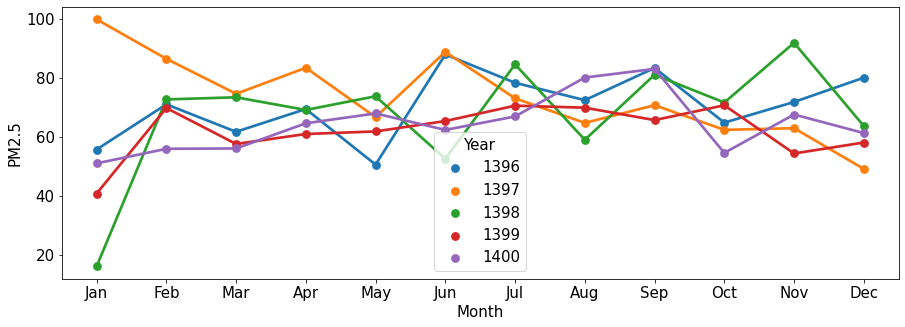

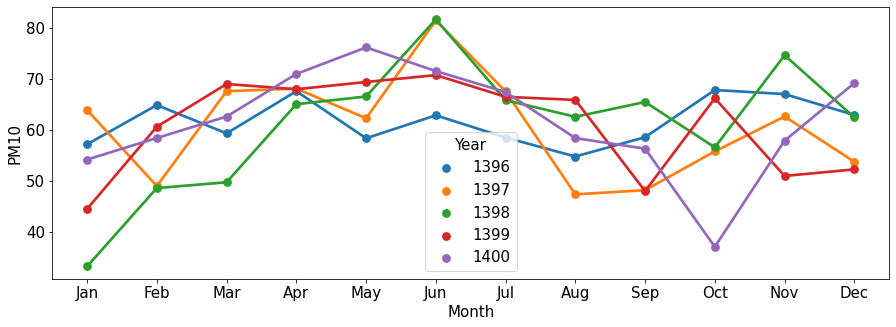

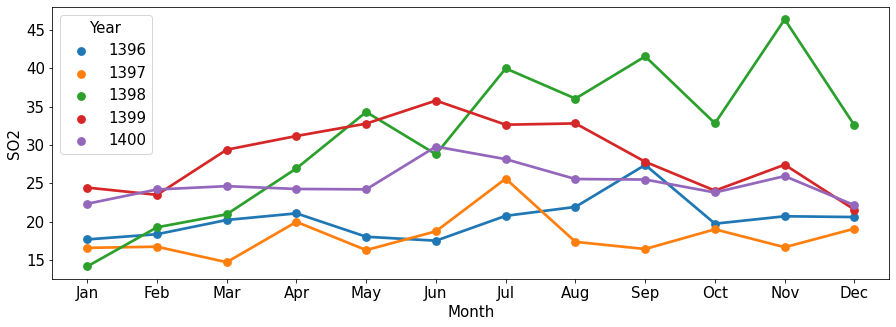

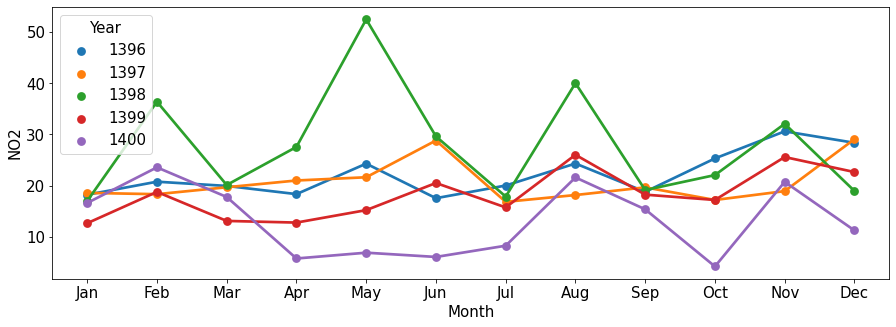

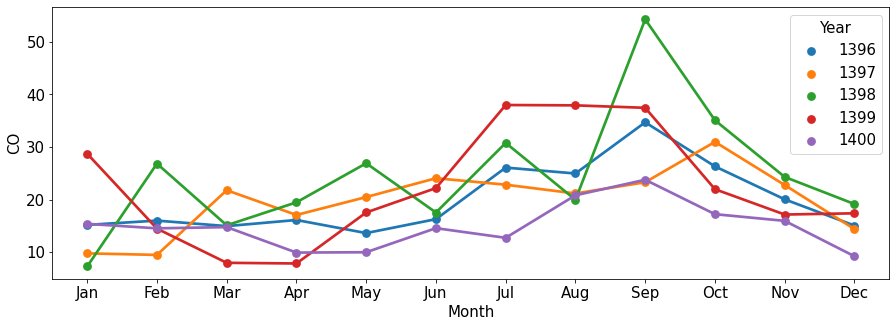

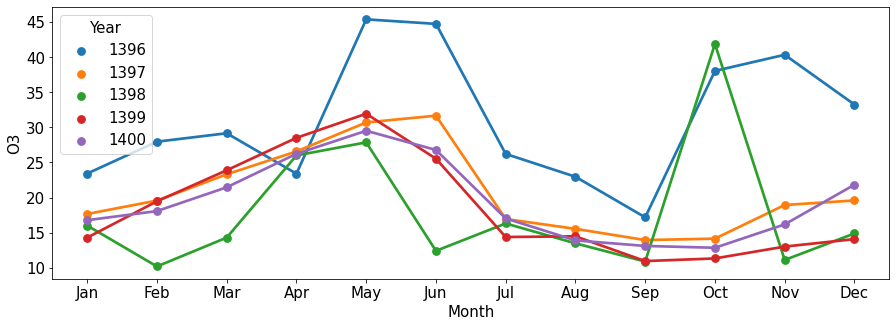

In [209]:
custom_dict = {'Jan':0, 'Feb':1, 'Mar':2, 'Apr':3, 'May':4, 'Jun':5,
               'Jul':6, 'Aug':7, 'Sep':8, 'Oct':9, 'Nov':10, 'Dec':11}
for i in compounds:    
    temp_data = data.copy()
    temp_data.Month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 
                                                               'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], inplace=True)
    df = temp_data[[i, 'Month', 'Year']].groupby(["Year",
                                                  "Month"]).mean().reset_index().sort_values(by=['Year', 
                                                                                                 'Month'], ascending=True)
    df = df.iloc[df['Month'].map(custom_dict).argsort()]
    f, ax=plt.subplots(figsize=(15, 5))
    sns.pointplot(x='Month', y=i, data=df, hue="Year")